#### Project 1 Numerical linear algebra 
This notebook is a supplement to the project report attached in the zip file. For theory, results and interpretation please read the report.  

Import relevant libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
plt.rcParams['lines.linewidth'] = 0.7


Create a function that generates s starting value for the temperatures in the beam, $T^{(0)}$, for some $h > 0$ 

In [3]:
def create_init_temp(h, T_left = 20, T_right = 100):
    '''
    create a grid of intial temperature with regard to boundary conditions
    inputs:     
        - h: step length in x and y direction 
    outputs:
        - T0: inital temperature for grid
    '''
    x_end = 10
    y_end = 14 
    N = int(x_end/h)
    M = int(y_end/h)
    T0 = 10*np.random.rand(N,M)

    T0[int(4/h)+1:int(10/h), 0:int(4/h)] = np.zeros_like(T0[int(4/h)+1:int(10/h), 0:int(4/h)])
    T0[int(4/h)+1:int(10/h), int(10/h):int(14/h)] = np.zeros_like(T0[int(4/h)+1:int(10/h), int(10/h):int(14/h)])

    T0[0, :] = T_left
    T0[0:int(4/h)+1, 0] = T_left
    T0[0:int(4/h)+1, -1] = T_left
    
    T0[N-1, int(4/h):(int(10/h)) ] = T_right
    return T0


Create a function that calculates the residual error for each $T_{i,j}$ :
$$
r_{i,j} \leftarrow \frac{T_{i,j+1} + T_{i,j-1} T_{i,j+1} + T_{i-1,j} - 4 T_{i,j}}{h^2}
$$

In [4]:
def residual(T):
    N,M = np.shape(T)
    res = np.zeros_like(T)
    h = 10/N
    for i in range(1,N-1):
        for j in range(1,M-1): 
            if(i*h >= 4 and (j*h >= 10.0-h or j*h <= 4.0)): #outside of feasible set
                continue
            else:
                res[i,j] = (T[i+1,j] + T[i-1, j] + T[i,j+1] + T[i, j-1] - 4*T[i,j])/h**2
    return res

Implement function which performs one iteration of the Gauss-Seidel method:
$$
T_{i,j} \leftarrow \frac{1}{4}\left( T_{i+1,j} + T_{i-1,j} + T_{i,j+1} + T_{i,j-1} \right)
$$

In [5]:
def GS_iteration(T0):
    '''
    one iteration with GS on the grid with neumann conditions

    input:
        - T0: Intial temperature 
    output:
        - T: proposed solution
    '''
    T = np.copy(T0)
    N,M = np.shape(T0)
    h = 10/N  
    for i in range(1, N-1): #along x
        for j in range(1, M-1): #along y 
            if(i*h > 4 and (j*h > 10.0-h or j*h < 4.0)): #outside of feasible set
                T[i,j] = 0
                continue
            elif(i*h == 4.0  and (j*h == 4.0 or j*h == 10.0-h)):
                T[i,j] = 1/4*(T[i+1,j] + T[i-1,j] + T[i, j+1] + T[i, j-1])

            elif(i*h == 4.0  and (j*h <= 4.0 or j*h >= 10.0-h)): #boundary along x = 4
                T[i,j] = 1/4*(T[i,j+1]+ T[i,j-1] + 2*T[i-1, j])
                continue
            elif((i*h >= 4.0 ) and (j*h == 4.0)): #boundary along y = 4  
                T[i,j] = 1/4*(2*T[i,j+1] + T[i-1,j] + T[i+1,j] )
                continue
            elif((i*h >= 4.0) and (j*h == 10.0-h)): #boundary along y = 10  
                T[i,j] = 1/4*(T[i+1,j] + T[i-1,j] + 2*T[i,j-1])
                continue
            else:
                T[i,j] = 1/4*(T[i+1,j] + T[i-1,j] + T[i, j+1] + T[i, j-1])
                continue
    return T


Implement gauss seidel method with a tolerance and max iteration as stopping criteria 

In [6]:
def gauss_seidel(T0, tol = 0.5**2, max_iter = 200):
    '''
    does gaus seidel a finite number with neumann condtions
    input: 
        - T0: intial temperature 
        - tol: tolerance for residual error
        - max_iter: numer of iterations
    output:
        - T: solution proposal 
        - residuals: resiudal error (not certain about this yet)
        - index: indicates amount of iterations
    
    '''
    residuals = []
    index = []
    i = 0
    T = np.copy(T0)
    res = np.linalg.norm(residual(T0).flatten())
    while(abs(res) > tol and i < max_iter):
        T = GS_iteration(T)
        res = np.linalg.norm(residual(T).flatten())
        residuals.append(res)
        i+=1
        index.append(i)
        
    return T, residuals, index


Plot for $h= 0.5$, tolerance $= 0$ (force the max iteration criteria) and max iteration = $500$

0.019132625163299558


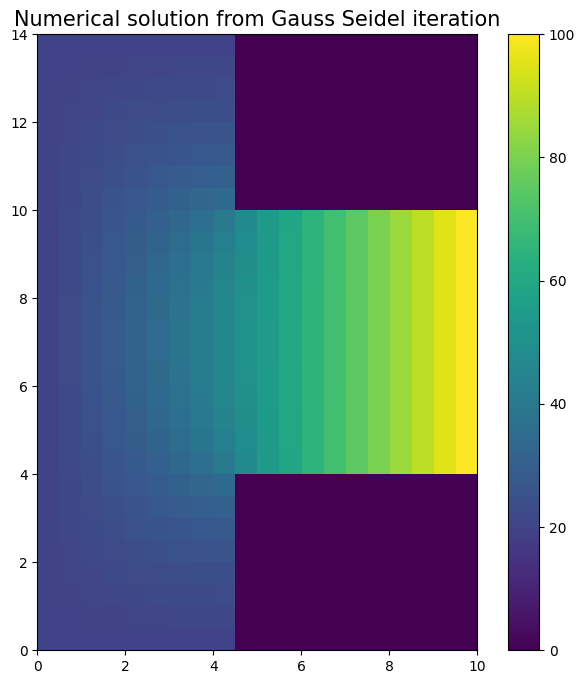

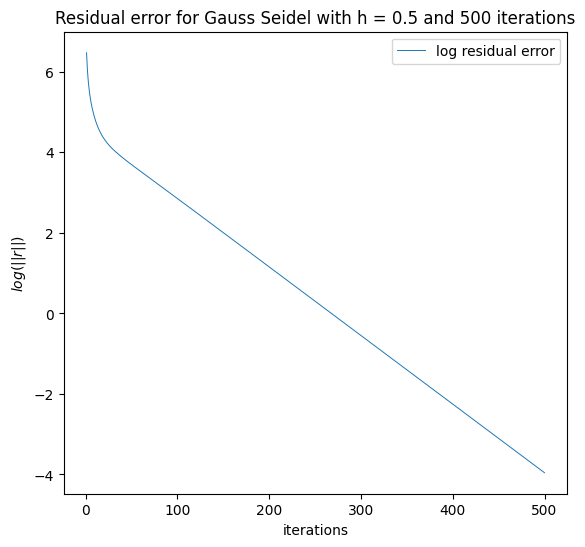

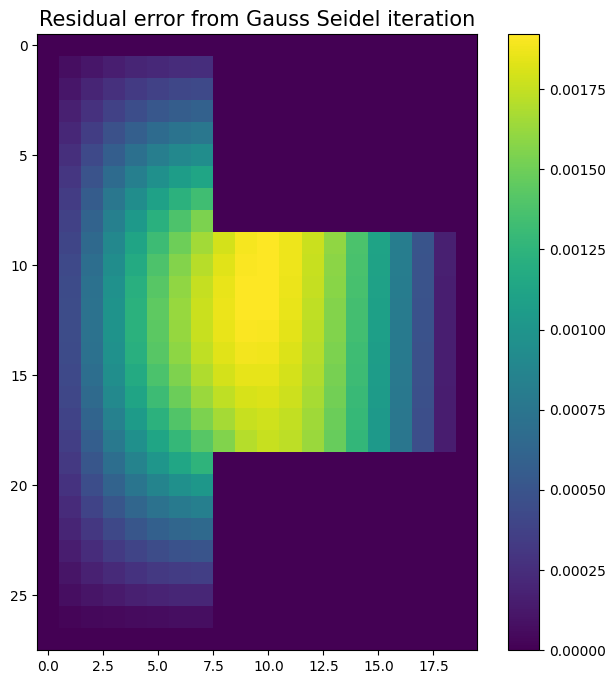

In [13]:
h = 0.5
T0 = create_init_temp(h, 20, 100)
T, residuals, index = gauss_seidel(T0, tol = 0, max_iter= 500)
print(np.linalg.norm(residual(T)))

plt.figure(figsize = (8,8))
plt.imshow(T.T)
plt.imshow(T.T, extent = [0,10, 0, 14])
plt.colorbar()
plt.title(r'Numerical solution from Gauss Seidel iteration', fontsize = 15)
plt.savefig('sol_pde.png')

plt.figure(figsize = (6.5,6))
plt.plot(index, np.log(residuals), label = r'log residual error')
plt.title(r'Residual error for Gauss Seidel with h = 0.5 and 500 iterations', fontsize = 12)    
plt.xlabel(r'iterations')
plt.ylabel(r'$log(||r||)$')
plt.legend()
plt.savefig('residual_error_GS.png')

plt.figure(figsize = (8,8))
res = residual(T)
plt.imshow(res.T)
plt.title(r'Residual error from Gauss Seidel iteration', fontsize = 15)
plt.colorbar()
plt.savefig('residual_error_plot_GS.png')

If we let the algorithm iterate for a large number of iterations we observe that we get zero residual error

0.0


/var/folders/21/q6thhsn14n7gnn88h4prdf1h0000gn/T/ipykernel_95306/3780189850.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(index, np.log(residuals), label = r'log residual error')


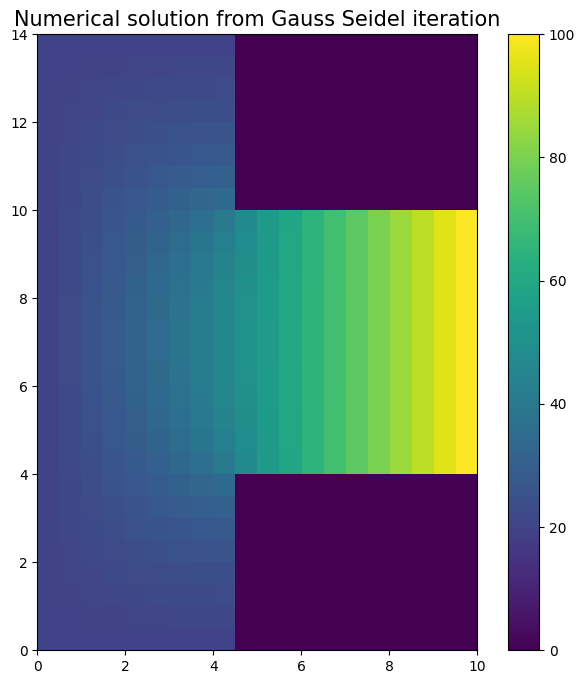

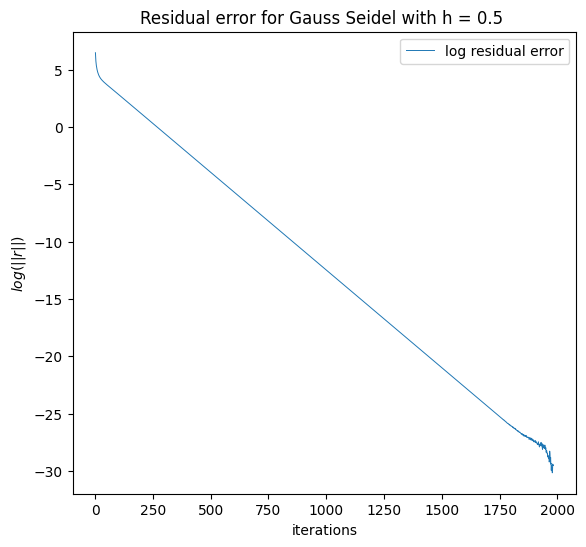

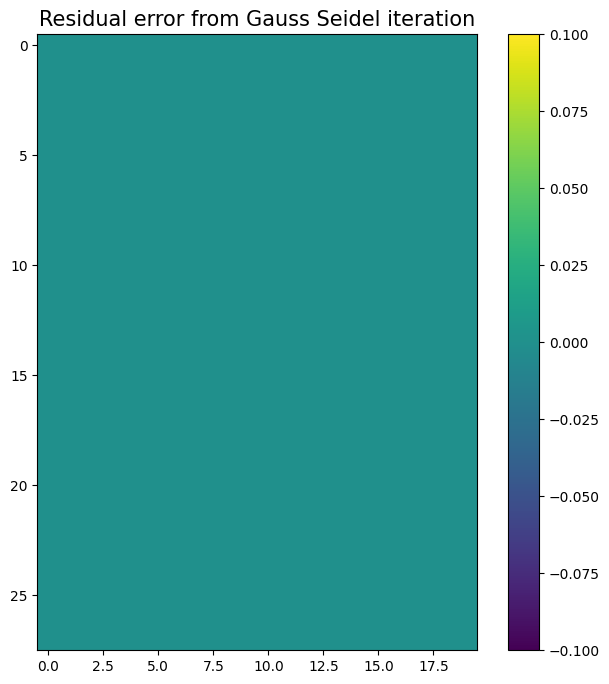

In [15]:
h = 0.5
T0 = create_init_temp(h, 20, 100)
T, residuals, index = gauss_seidel(T0, tol = 0, max_iter= 10000)
print(np.linalg.norm(residual(T)))

plt.figure(figsize = (8,8))
plt.imshow(T.T)
plt.imshow(T.T, extent = [0,10, 0, 14])
plt.colorbar()
plt.title(r'Numerical solution from Gauss Seidel iteration', fontsize = 15)

plt.figure(figsize = (6.5,6))
plt.plot(index, np.log(residuals), label = r'log residual error')
plt.title(r'Residual error for Gauss Seidel with h = 0.5 ', fontsize = 12)    
plt.ylabel(r'$log(||r||)$')
plt.xlabel(r'iterations')
plt.legend()

plt.figure(figsize = (8,8))
res = residual(T)
plt.imshow(res.T)
plt.title(r'Residual error from Gauss Seidel iteration', fontsize = 15)
plt.colorbar()

Numerical solution with Gauss-Seidel for $h = 0.25$, tol = $h^2$ and max iterations = $10000$

0.062423385652290116 1996


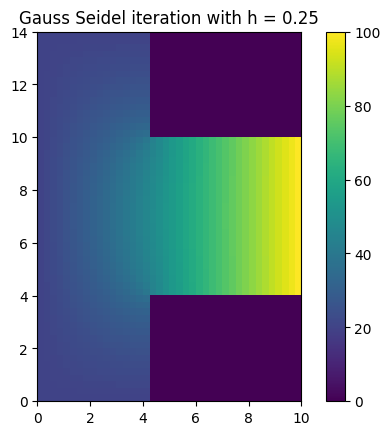

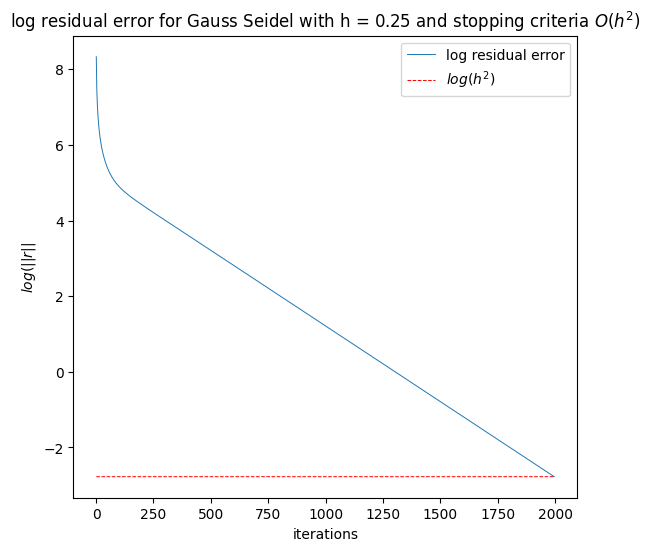

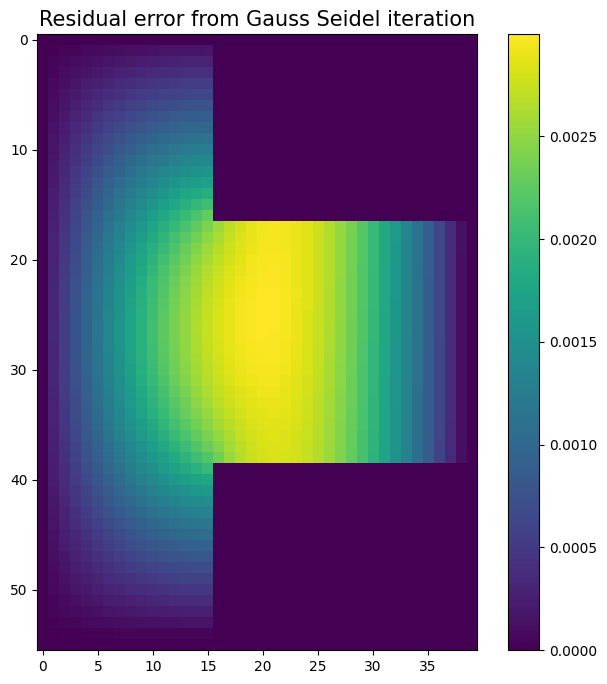

In [32]:

h = 0.25
T0 = create_init_temp(h, 20, 100)
T, residuals, index = gauss_seidel(T0, tol = h**2, max_iter=10000)

print(residuals[-1], index[-1])
plt.imshow(T.T)
plt.imshow(T.T, extent = [0,10, 0, 14])
plt.colorbar()
plt.title(r'Gauss Seidel iteration with h = 0.25', fontsize = 12)
plt.savefig('sol_pde_2.png')

plt.figure(figsize = (6.5,6))
plt.plot(index, np.log(residuals), label = r'log residual error')
plt.plot(index, np.log(h**2)*np.ones_like(residuals), 'r--', label = r'$log(h^2)$')
plt.title(r'log residual error for Gauss Seidel with h = 0.25 and stopping criteria $O(h^2)$', fontsize = 12)
plt.xlabel(r'iterations')
plt.ylabel(r'$log(||r||$')
plt.legend()
plt.savefig('residual_error_plot_GS_2.png')

plt.figure(figsize = (8,8))
res = residual(T)
plt.imshow(res.T)
plt.title(r'Residual error from Gauss Seidel iteration', fontsize = 15)
plt.colorbar()  

Plot of the numerical solution for $h = 0.5$, tol = $h^2$ and max iterations = $500$

0.2486934561641559 349


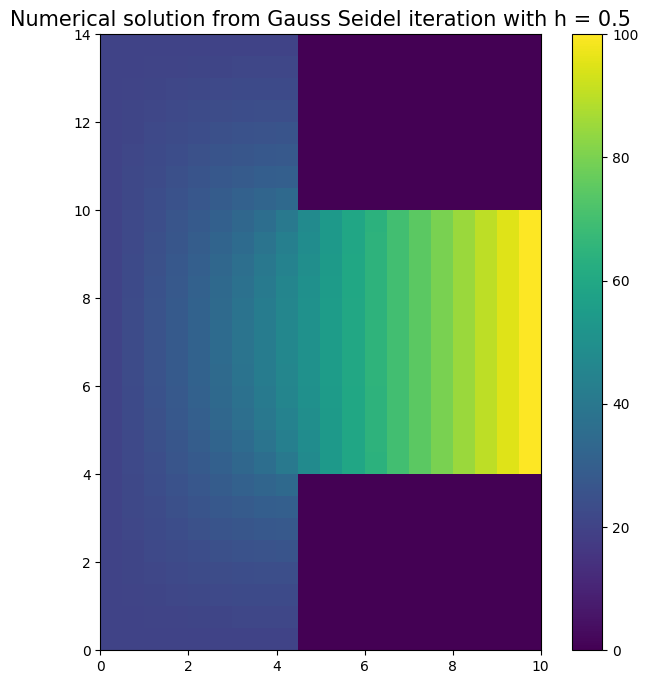

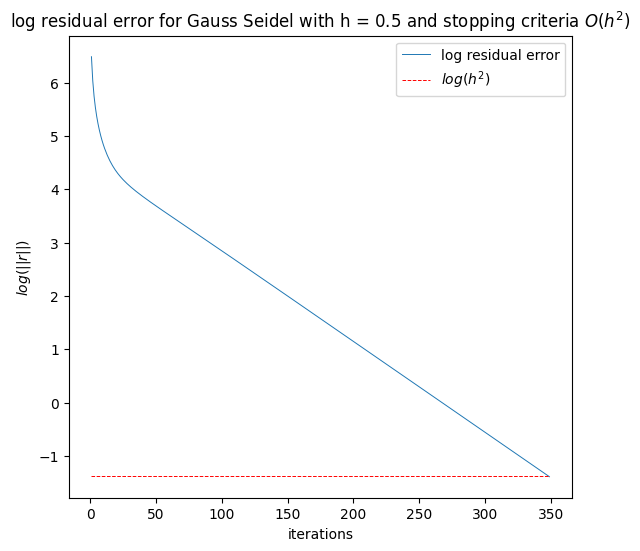

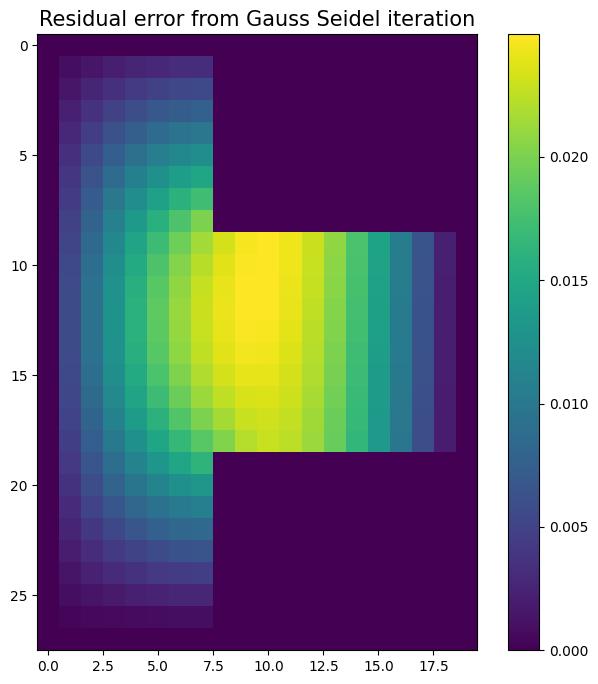

In [29]:
h = 0.5
T0 = create_init_temp(h)
T, residuals, index = gauss_seidel(T0, max_iter = 500, tol = h**2)
plt.figure(figsize = (8,8))

print(residuals[-1], index[-1])
plt.imshow(T.T)
plt.imshow(T.T, extent = [0,10, 0, 14])
plt.colorbar()
plt.title(r'Numerical solution from Gauss Seidel iteration with h = 0.5', fontsize = 15)
plt.savefig('sol_pde_0.5.png')

plt.figure(figsize = (6.5,6))
plt.plot(index, np.log(residuals), label = r'log residual error')
plt.plot(index, np.log(h**2)*np.ones_like(residuals), 'r--', label = r'$log(h^2)$')
plt.title(r'log residual error for Gauss Seidel with h = 0.5 and stopping criteria $O(h^2)$', fontsize = 12)
plt.xlabel(r'iterations')
plt.ylabel(r'$log(||r||)$')
plt.legend()
plt.savefig('residual_error_plot_GS_0.5.png')

plt.figure(figsize = (8,8))
res = residual(T)
plt.imshow(res.T)
plt.title(r'Residual error from Gauss Seidel iteration', fontsize = 15)
plt.colorbar()  

Implement function for one iteration of SOR-method:
$$
T_{i,j}\leftarrow (1-\omega)T_{i,j} + \frac{\omega}{4}\left( T_{i+1,j} + T_{i-1,j} + T_{i,j+1} + T_{i,j-1} \right),
$$

In [22]:
def SOR_iteration(T0, omega):
    '''
    one iteration with GS on the grid with neumann conditions

    input:
        - T0: Intial temperature 
    output:
        - T: proposed solution
    '''
    T = np.copy(T0)
    N,M = np.shape(T0)
    h = 10/N  
    for i in range(1, N-1): #along x
        for j in range(1, M-1): #along y 
            if(i*h > 4 and (j*h > 10.0-h or j*h < 4.0)): #outside of feasible set
                T[i,j] = 0
                continue
            elif(i*h == 4.0  and (j*h == 4.0 or j*h == 10.0-h)):
                T[i,j] = (1-omega) *T[i,j] + omega/4*(T[i+1,j] + T[i-1,j] + T[i, j+1] + T[i, j-1])

            elif(i*h == 4.0  and (j*h <= 4.0 or j*h >= 10.0-h)): #boundary along x = 4
                T[i,j] = (1-omega) *T[i,j] + omega/4*(T[i,j+1]+ T[i,j-1] + 2*T[i-1, j])
                continue
            elif((i*h >= 4.0 ) and (j*h == 4.0)): #boundary along y = 4  
                T[i,j] = (1-omega) *T[i,j] + omega/4*(2*T[i,j+1] + T[i-1,j] + T[i+1,j] )
                continue
            elif((i*h >= 4.0) and (j*h == 10.0-h)): #boundary along y = 10  
                T[i,j] = (1-omega) *T[i,j] + omega/4*(T[i+1,j] + T[i-1,j] + 2*T[i,j-1])
                continue
            else:
                T[i,j] = (1-omega) *T[i,j] + omega/4*(T[i+1,j] + T[i-1,j] + T[i, j+1] + T[i, j-1])
                continue
    return T

Implement function for the iterative solcer SOR with tolerance and a maximum number of iterations

In [23]:
def SOR(T0, omega, tol = 0.5**2, max_iter = 200):
    '''
    does gaus seidel a finite number of times with neumann conditions
    input: 
        - T0: intial temperature 
        - tol: tolerance for residual error
        - max_iter: numer of iterations
    output:
        - T: solution proposal 
        - residuals: resiudal error (not certain about this yet)
        - index: indicates amount of iterations
    '''
    residuals = []
    index = []
    i = 0
    T = np.copy(T0)
    res = np.linalg.norm(residual(T))
    while(i < max_iter and res > tol):
        T = SOR_iteration(T, omega)
        res = np.linalg.norm(residual(T))
        residuals.append(res)
        i+=1
        index.append(i)
    return T, residuals, index

Experimentally compute the optimal choice of $\omega$

In [25]:
h = 0.5
T0 = create_init_temp(h)
omega = np.linspace(0, 2, 100, endpoint = False)[1:]
indexes = []
for w in omega:
    T, residuals, index = SOR(T0, w, max_iter=1000, tol = h**2)
    indexes.append(index[-1])


Numerical solution from the SOR method with optimal $\omega$

In [26]:
print(f'optimal omega for SOR = {omega[np.argmin(indexes)]}')
h = 0.5
T0 = create_init_temp(h)
T, residuals, index = SOR(T0, omega[np.argmin(indexes)] , max_iter = 1000, tol = h**2)

optimal omega for SOR = 1.76


Plot of numerical solution, residual error, convegence and number of iterations for each $\omega$.

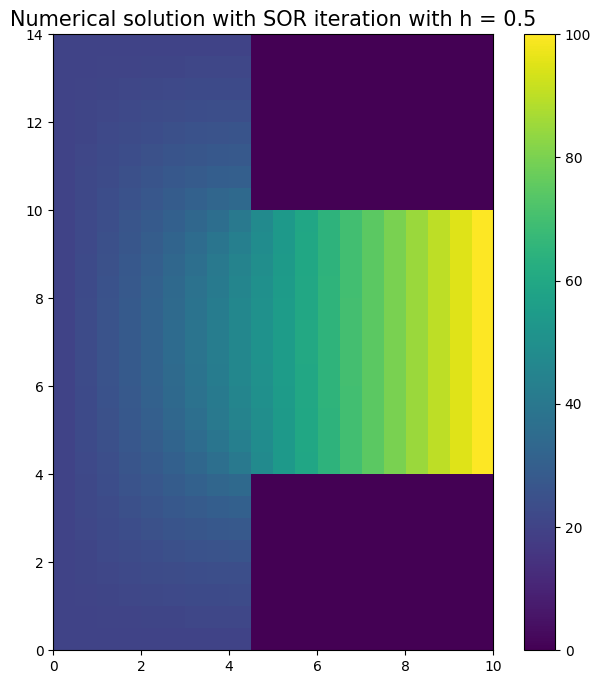

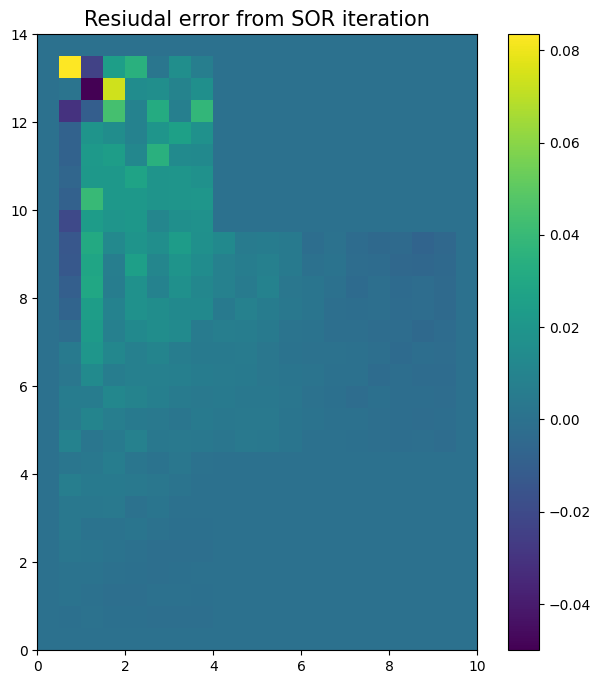

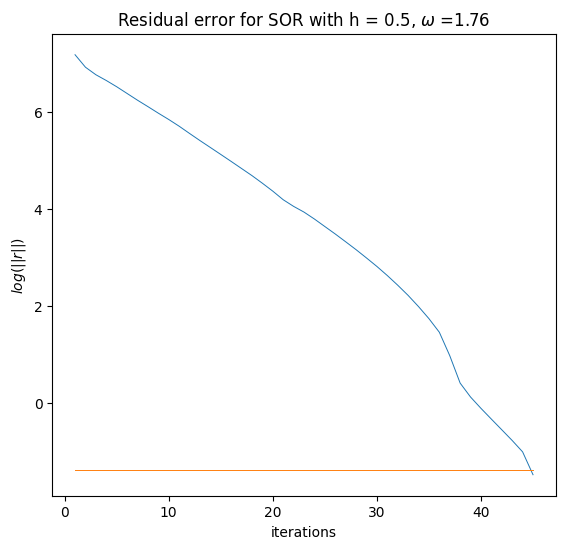

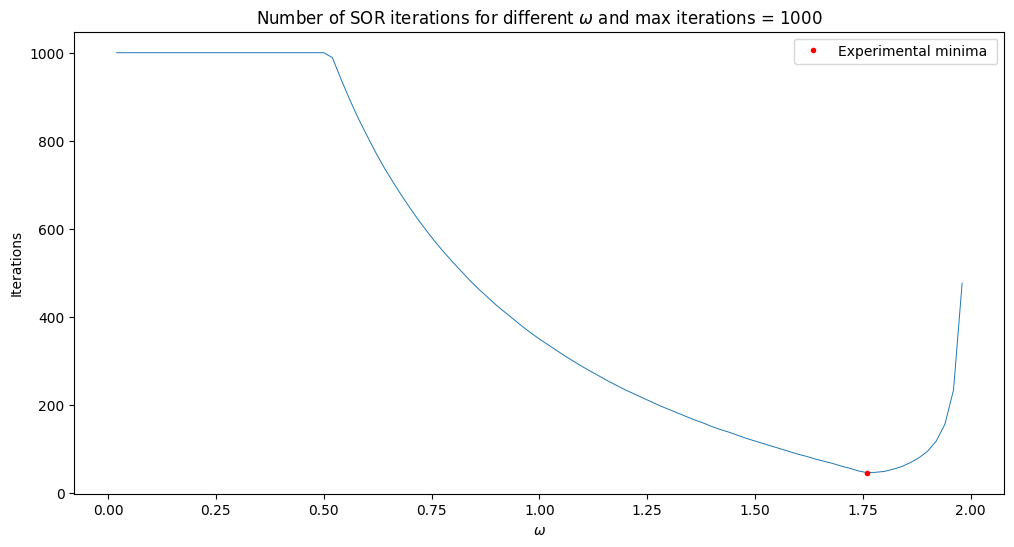

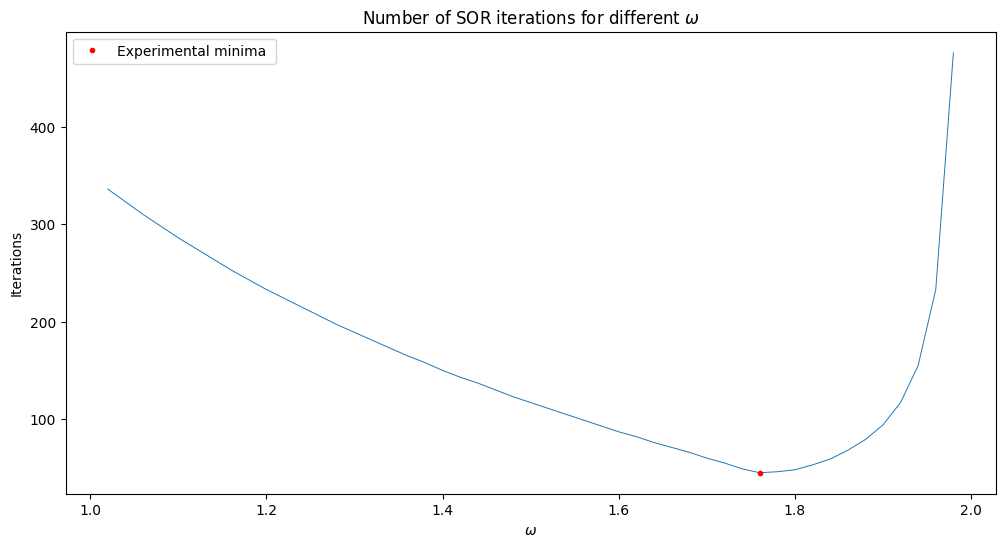

In [27]:
plt.figure(figsize = (8,8))
plt.title(r'Numerical solution with SOR iteration with h = 0.5', fontsize = 15)
plt.imshow(T.T, extent = [0,10,0,14])
plt.colorbar()
plt.savefig('SOR_sol.png')

plt.figure(figsize = (8,8))
plt.imshow(residual(T).T, extent = [0,10,0,14])
plt.colorbar()
plt.title(r'Resiudal error from SOR iteration', fontsize = 15)
plt.savefig('residual_error_SOR.png')

plt.figure(figsize = (6.5,6))
plt.plot(index, np.log(residuals), label = r'log residual error')
plt.plot(index, np.log(h**2) * np.ones_like(residuals), label = r'$log(h^2)$')
plt.title(r'Residual error for SOR with h = 0.5, $\omega$ =' f'{omega[np.argmin(indexes)]}' )
plt.xlabel(r'iterations')
plt.ylabel(r'$log(||r||)$')
plt.savefig('residual_error_plot_SOR.png')

plt.figure(figsize = (12,6))   
plt.plot(omega, indexes)
plt.plot(omega[np.argmin(indexes)], min(indexes), 'r.', label = 'Experimental minima ')
plt.title(r'Number of SOR iterations for different $\omega$ and max iterations = 1000')
plt.xlabel(r'$\omega$')
plt.ylabel(r'Iterations')
plt.legend()
plt.savefig('optimal_omega1.png')

plt.figure(figsize = (12,6))   
plt.plot(omega[50:], indexes[50:])
plt.plot(omega[np.argmin(indexes)], min(indexes), 'r.', label = 'Experimental minima ')
plt.title(r'Number of SOR iterations for different $\omega$')
plt.xlabel(r'$\omega$')
plt.ylabel(r'Iterations')
plt.legend()

plt.savefig('optimal_omega2.png')
